
## Time series forecasting  With FBprophet 

Prophet was specifically crafted to handle business forecasting tasks effectively, particularly those with the following characteristics:

Time series data captured at different levels (hourly, daily, or weekly), ideally spanning at least a year of historical data

Pronounced seasonality effects occurring daily, weekly, and/or yearly

Irregular occurrences of holidays and unique events that do not follow typical seasonality patterns

Presence of missing data points and outliers

Significant shifts in trends, often coinciding with the introduction of new features or products, for instance

Prophet operates as an additive regression model, meaning it combines several (optional) components, including:

A linear or logistic growth trend curve
Annual seasonality curve
Weekly seasonality curve
Daily seasonality curve
Holidays and other special events
Additional user-defined seasonality curves, such as hourly or quarterly patterns
Internally, Prophet is implemented in Stan, a probabilistic programming language (refer to the home page at https://mc-stan.org/ for more details on Stan). This choice offers various advantages, enabling Prophet to optimize the fitting process, usually completing within a second. Stan is compatible with both Python and R, allowing the Prophet team to utilize the same core fitting procedure in both languages. Additionally, leveraging Bayesian statistics through Stan allows Prophet to generate uncertainty intervals for future predictions, incorporating a data-driven estimate of forecasting risk.

Prophet consistently achieves results comparable to more intricate forecasting techniques but with significantly reduced complexity. It caters to a wide range of users - beginners can quickly build highly accurate models with just a few lines of code, without delving into the inner workings, while experts can delve deep, adding more features and fine-tuning hyperparameters to attain incremental performance improvements."



In [168]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from prophet import Prophet
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from matplotlib import rcParams
plt.style.use("ggplot")
rcParams['figure.figsize'] = (15, 6)
import warnings 
import plotly.io as pio
pio.renderers.default = 'iframe'

warnings.filterwarnings('ignore')



In [169]:
df = pd .read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv" , parse_dates = True)

## I - Explore the data and seasonalities 

In [3]:
print(df.head(1))

print(df.tail(1))

             timestamp  value
0  2014-07-01 00:00:00  10844
                 timestamp  value
10319  2015-01-31 23:30:00  26288


- The data ranges from "2014-07-01" to "2015-01-31" and it has hourly frequency . 




- **The granularity of the data is so much high , so it's better to reduce it in order , to improve our visuals .**


In [118]:
df["timestamp"] = pd.to_datetime(df["timestamp"])


In [119]:
df = df.set_index("timestamp").resample("H").mean().reset_index()

In [15]:
df

,timestamp,value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [120]:
fig = px.line(df, x="timestamp" , y ="value" , title = "New york taxi passengers serie")

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(height=600, width=1000)
fig.show()

- There is some kind of seasonality in the data , after zooming on it multiple time , we can observe a daily seasonality . 

- There is some outliers in the data . 

- Also the time serie seems to be additive not multiplicative because the magnitude of each season is not proportional to the trend . 
- There is some tips , like when there is count data in our time series , we usually go for a multiplicative model 
- There is no strong trend component in the data  .but strong seasonal effect


## I-1 Catching seasonalities 

In [7]:
df["hour"] = df.timestamp.dt.hour

df["month"]  = df["timestamp"].dt.month

df["weekday"]  = pd.Categorical(df.timestamp.dt.strftime("%A") , categories = ["Monday" ,"Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

### Hourly agregated data

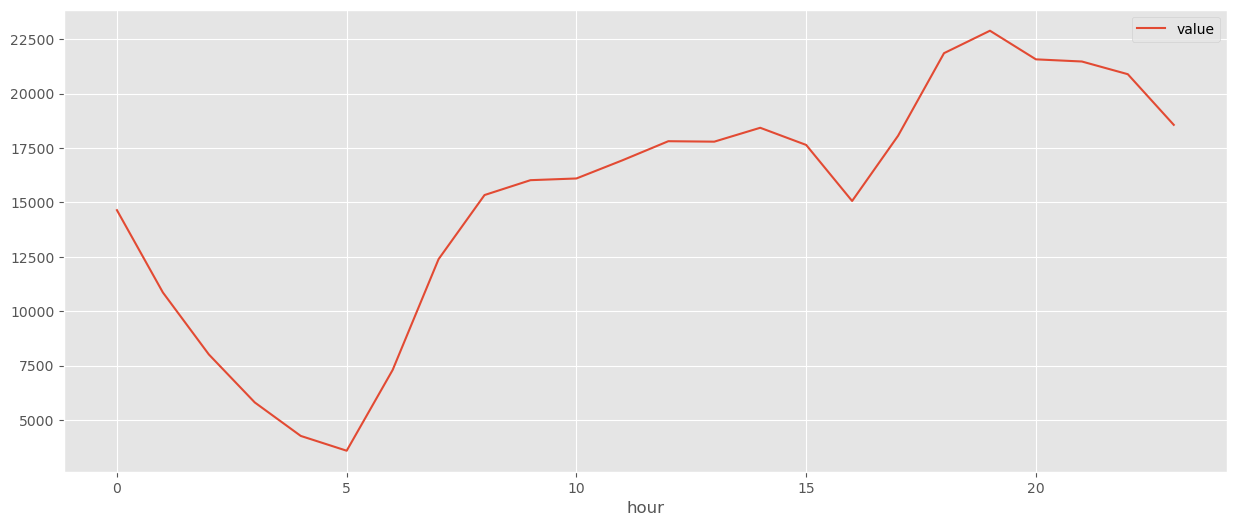

In [8]:
df[["value","hour"]].groupby('hour').mean().plot() ;


The demand is the lowest  in 5 AM or mornings in general  ,  and highest in 7 pm on average . this is because most people finish their work  around 7 pm or 6 pm , so taxi demands are highest in these times 



### daily agregated data

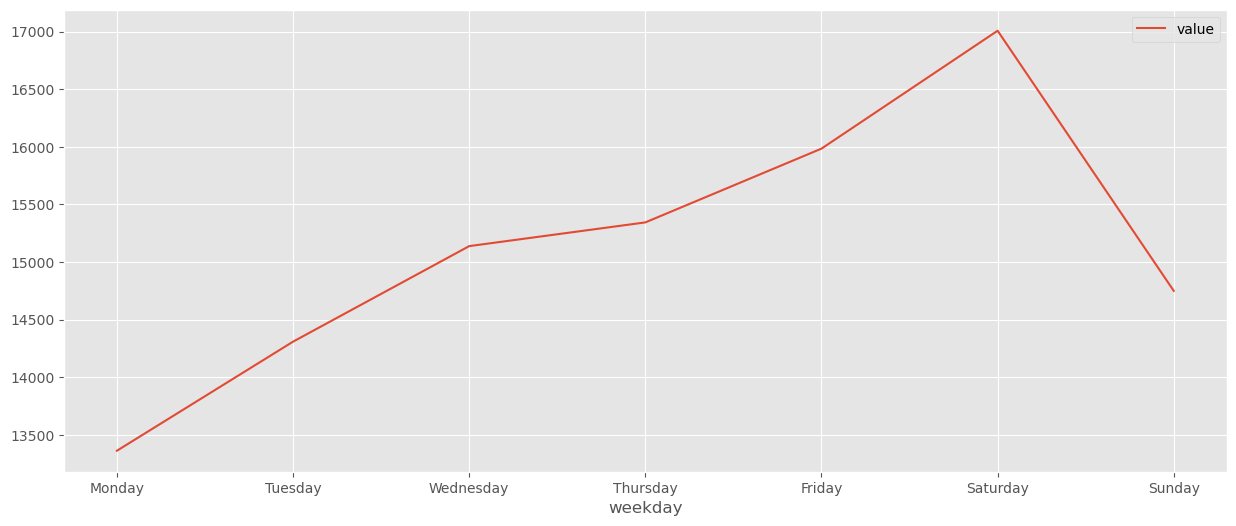

In [9]:
df[["value","weekday"]].groupby('weekday').mean().plot();

- This is the overall behaviour of the data , we can always use an unstacked plot to understand the seasonalities in the data 

### Unstacked plot 


- We should agregate data using two different time scales that are weekday and month , or hour and weekday etc . , this will help us in our understanding of the underlying seasonalities in the data , and likely to look out after some anomalies . 




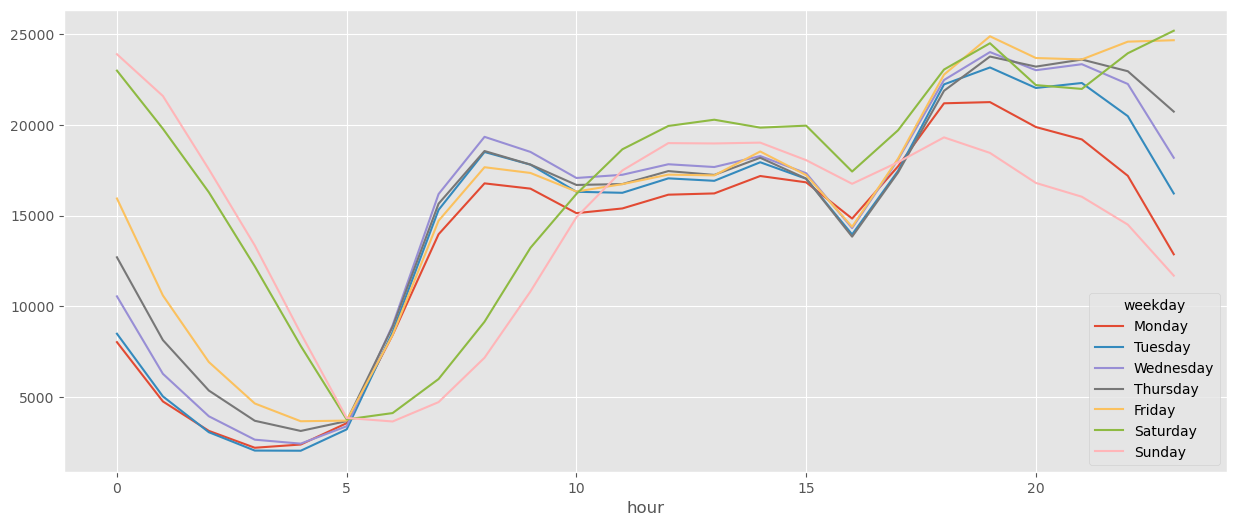

In [10]:
df.groupby(["hour","weekday"]).mean()["value"].unstack().plot();


The saturday and sunday have different behaviours than normal days , and they exhibit similar pattern in some way .
This not our worry right now  , it can be diagnosed in further analysis , to improve our forecast . 



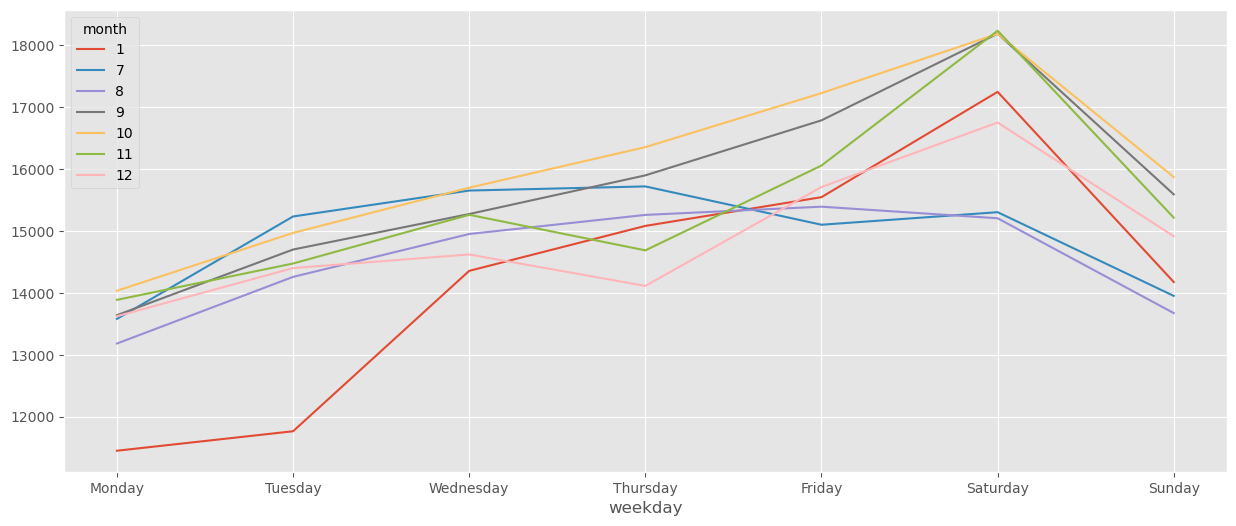

In [11]:
df.groupby(["weekday","month"]).mean()["value"].unstack().plot();


<u><b> Summary  :</b></u> 

- The taxi demands , are the highest in saturdays , so there is some kind of weekly pattern , and there is  daily pattern .
- There is some anomalies in the data that can be diagnosed also .  

-  The fact that the data exhibit strong seasonal effect in the data , it is interesting to use some algorithmes like prophet .

## II - Modeling with Fbprophet



- When Prophet was first released, it assumed all data would be on a daily scale, with one 
row of data per day. It has since grown to handle many different granularities of data, but 
because of its historical conventions, there are few things to be cautious of when working 
with non-daily data . 

- So by Default the Fbprophet is configured to use daily data .we must change it .
- There is also another issue is with seasonality , we must specify if it's multiplicative or additive , but we said earlier that is additive through visuals  because the magnitude of seasonal components don't change with trend mostly .


- It's important to format our timestamps to datetime object , when working with timeseries data , it's a good practice because we benifit from methods related to these objects such as  slicing etc . 

- and also there is a coonventional form of the data used by fbprophet we must format our data in the following form 




In [186]:

df = pd .read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv" , parse_dates = True)

df["timestamp"] = pd.to_datetime(df["timestamp"])

df = df.set_index("timestamp").resample("H").mean().reset_index()




In [187]:
df.columns  = ["ds","y"]

In [4]:
df.tail(40)


,ds,y
5120,2015-01-30 08:00:00,20878.5
5121,2015-01-30 09:00:00,19101.0
5122,2015-01-30 10:00:00,16828.5
5123,2015-01-30 11:00:00,16903.0
5124,2015-01-30 12:00:00,16829.5
5125,2015-01-30 13:00:00,17381.0
5126,2015-01-30 14:00:00,18504.0
5127,2015-01-30 15:00:00,17740.0
5128,2015-01-30 16:00:00,15150.5
5129,2015-01-30 17:00:00,19291.0


In [188]:
# Initialize the prophet object , by default  Prophet is configured with additive seasonality mode 

model = Prophet(seasonality_mode='additive')


model.fit(df)

13:47:55 - cmdstanpy - INFO - Chain [1] start processing
13:47:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet analyzed the data and isolated both the seasonality 
and trend without requiring us to specify any additional parameters.


To make some forecasts, we need to first make a DataFrame of future dates 
and then call the predict method. The make_future_dataframe method requires 
us to specify the number of days we intend to forecast out. In this case, we will choose 3months  ahead 

In [189]:
# Creating a future object 


future = model.make_future_dataframe(periods=0,freq='H')


# Call the predict method 


forecast = model.predict(future)

- At this point, the forecast DataFrame contains Prophet's prediction for hourly taxi passengers for  all the dataframe , 

- We will explore that DataFrame after but first let's plot the data using Prophet's plot functionality.

- The plot method is built upon Matplotlib; it requires a DataFrame output from the predict method (our forecast DataFrame in this example).

In [190]:
print(f"Shape of predicted data :{forecast.shape[0]} \nShape of initial data : {df.shape[0]} ")

Shape of predicted data :5160 
Shape of initial data : 5160 


**Uncertainty in predictions : Prophet shows wider uncertainty intervals when it attempts to fit additive seasonality to a series of data 
containing multiplicative seasonality. Prophet knows that it does not have a good fit in the 
former model and is less certain about its predictions**

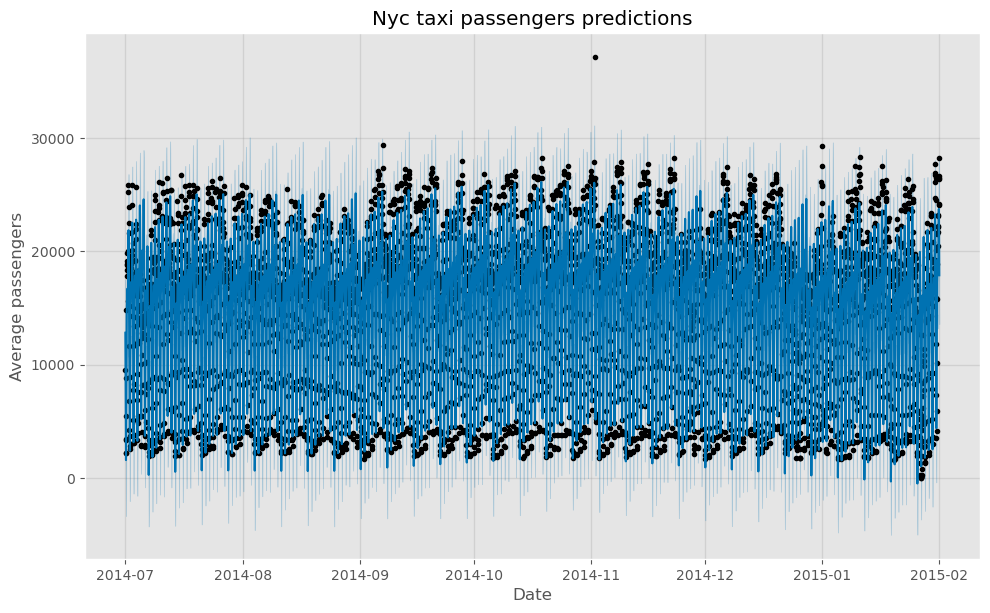

In [191]:
# The plot is too dense , so it better to zoom  on the lastest observations or predictions 
fig = model.plot(forecast, xlabel='Date', 
                 ylabel=r'Average passengers')
plt.title('Nyc taxi passengers predictions')
plt.show()

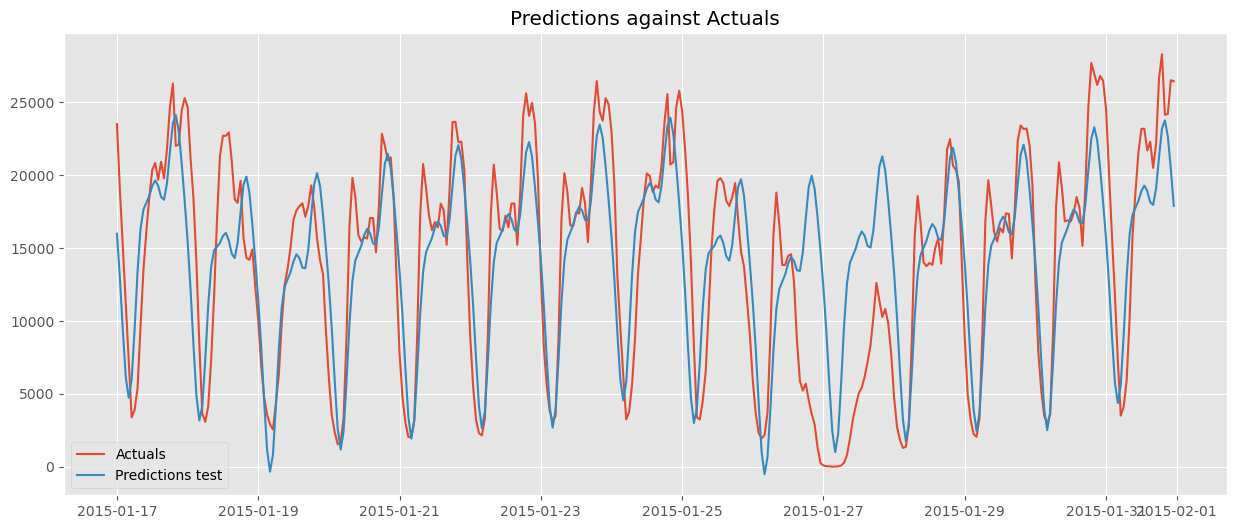

In [192]:
predictions = forecast.yhat
actuals = df.y

last_15_obs = df.iloc[-15*24:,:]


plt.plot(last_15_obs.ds , last_15_obs.y , label = "Actuals")





plt.plot(last_15_obs.ds,predictions[-last_15_obs.shape[0]:].values.tolist(),label = "Predictions test")

#plt.plot(last_200_obs.ds,predictions[len_df-200:len_df-24].values.tolist() + [None for i in range(test.shape[0])],label = "Predictions train")

plt.legend()

plt.title("Predictions against Actuals")
plt.show()

- The model seems to catch so well the  pattern in the data . but it affected with some anomalies due to some outliers , we see that in the date : "2015-01-27" it turns out that it coincides with North American blizzard  event . , after we'll try to handle these outliers 

In [180]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = forecast.yhat
actuals = df.y
rmse = np.sqrt(mean_squared_error(actuals,predictions))
mae = mean_absolute_error(actuals,predictions)



In [181]:
## metrics for additive models 
print(f"RMSE :{rmse} , MAE : {mae}")

RMSE :3747.070382992499 , MAE : 2848.8802957244397


In [156]:
## metrics for multiplicative models 
print(f"RMSE :{rmse} , MAE : {mae}")

RMSE :4141.812188515446 , MAE : 3121.055644176253


After calcuting performance metrics , on multiplicative/additive model it seems that the error is lower for the additive one which is an additional argument for our choice . 
Also we need to be careful when choosing the metrics for evaluation in our case what matters the most is MAE because we suffer from anomalies in the data , but we are interested in knowing if the model catches the important pattern in the data .
MAE is a good choice because it's robust to outliers . 
we'll try after to see if we can improve our forecasts n by taking into consideration these outliers  . 

## Plotting components of forecast


#####  Fourier orders and overfitting 




- As you may know Seasonality is at the heart of how Prophet works, Seasonalities can be catched using different smoothing techniques such as : kernels in cnns and fourier transforms , moving averages ... 
- Prophet use Fourier transforms , it'll decompose it into several sine waves with different phases , periods , and amplitude , to create these components . 

- In the linear domain , if you wanna fit a curve with many features you'll face a complex model that may lead to overfitting ,it's the same case for the periodic domain increasing Fourier orders or in other words how many sine waves the original signal will be decomposed to may lead to overfitting and obviously decreasing it so much will result in an underfitted  model . 


- By default Prophet fits yearly seasonality if there is any yearly seasonality ,  with an order of 10 and  weekly seasonality with an  order of 3 then  daily seasonality(same thing for sub-daily data)  of 4. Usually, these orders often work well , but they can be changed .

- The Fourier orders can be adjusted when instantiating the prophet object  . 

- So our goal is to find a model , with an appropriate fourier orders , that generelizes the overall characteristics of our data . 


- It's important  to adjust how many sine waves the signal will be decomposed to , because we may have overfitting ,

- Plotting the individual components of the forecast (trend, seasonality, and holidays) provides a clear and intuitive visualization of how each component contributes to the overall forecast.


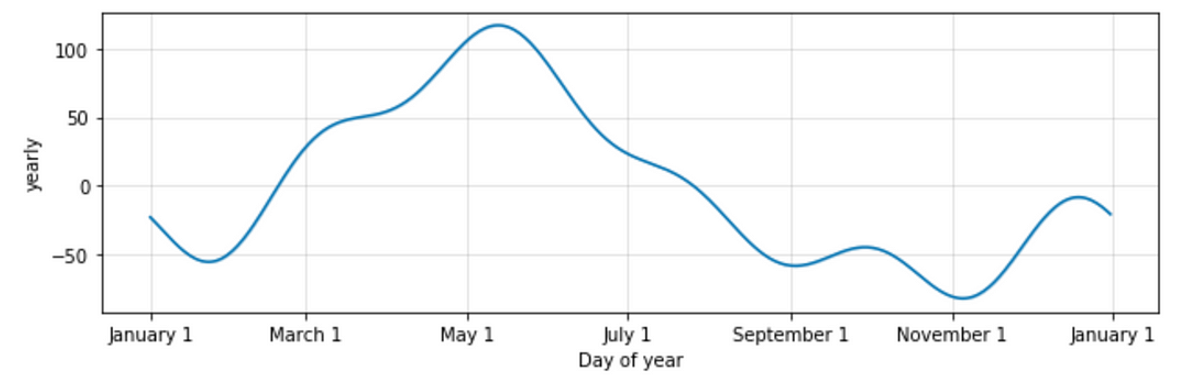

- For example ,  a  simpler time serie with  patterns we are aware of  , like this , is more likely to be the result of an overfitted model , catching more noise in the data , so we need to decrease the fourier order for that component (daily,weekly ... etc )  



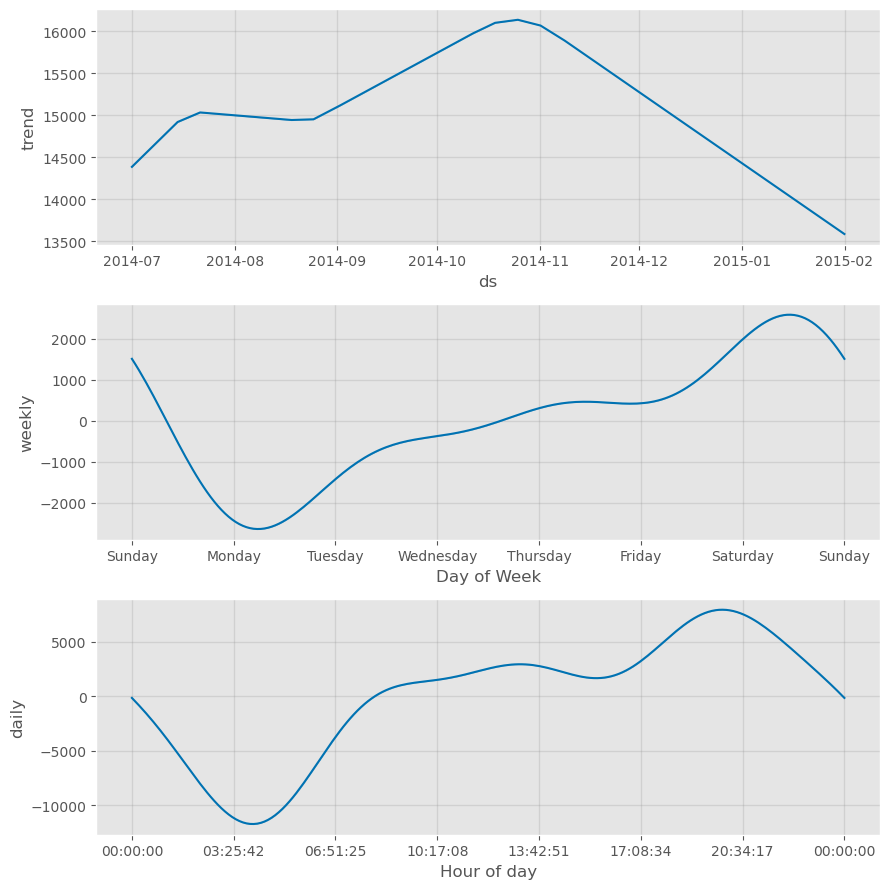

In [13]:
fig2 = model.plot_components(forecast)
plt.show()

- In our case the model is catching important patterns in the data , the daily and weekly components are so similar to the plots of aggregated data or unstacked plots . and they are not that very wavy .



##### Additive and multiplicative models intuition 

- In the multiplicative model the y-axis represent the a percentage of deviation of the component from the trend because the values of each seasonal component depend on the variation of the trend .so it's a percetange of the trend .

- In an additive one it's simply an additional factor to the trend , because it's magnitude is independant from the trend .

- How much you gonna add to the trend on average so we take can take  into account this seasonal effect in our model . 


##### Seasonalities 

- Sometimes the data may exhibit different seasonalities , like quarter seasonalities , so it's not logical , to model seasonalities that doesn't exist in our data , so we can use custom seasonalities in our model , and also sometimes some  seasonalities are not important in the data they may add just noise so it's better not to include them . we can adjust these things the way we want to improve our forecast . 

- In our case it's much more simpler 






### Anomalies detection 



- An anomaly , occurs in time series data , when a data-point  diverges from the distribution of the datapoints in the data in some context . 

- Based on our forecast  , we can see clearly that the  seasonal pattern was disrupted in some timestamps in our data , precisely in 26-27.01.2015 , which coicides with The North American blizzard, which affect the traffic in general , so a nice approach approach to follow is trying to detect these anomalies in order to improve our forecast .

- There are other events affecting our data  , after more digging we can summarize the following events that are affecting the behaviour of our time series data  : 

    - NYC Marathon : 2014-11-02
    - Thanksgiving - 2014-11-27
    - Christmas -2014-12-25
    - New Years - 2015-01-01
    - Snow Blizzard - 2015-01-26 and 2015-01-27



- Let's take a brief look into our dataframe , for this we are going to group our data by 'hour' and 'weekday' , and compute the average values of our time serie to see it's general behaviour .during these special days .



In [16]:
## Qualitative visualizations of anomalous data points 

df = pd .read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv" , parse_dates = True)
df["timestamp"] = pd.to_datetime(df["timestamp"])

df = df.set_index("timestamp").resample("H").mean().reset_index()

df["hour"] = df.timestamp.dt.hour

df["weekday"]  = pd.Categorical(df.timestamp.dt.strftime("%A") , categories = ["Monday" ,"Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])


df_final = df.join(df.groupby(['hour','weekday'])["value"].mean() , on = ["hour","weekday"] , rsuffix = "_avg")



In [20]:
df.describe()

,value,hour
count,5160.000000,5160.000000
mean,15137.569380,11.500000
std,6879.890431,6.922857
min,9.500000,0.000000
25%,9547.875000,5.750000
50%,16913.000000,11.500000
75%,19641.125000,17.250000
max,37204.500000,23.000000


In [18]:
#NYC Marathon : 2014-11-02

df_final.set_index('timestamp').loc['2014-11-02']

# The  median value of the data is 16913 , we can see clearly during the NYC Marathon event drops to some lowest values like 3837 in the morning 


,value,hour,weekday,value_avg
timestamp,,,,
2014-11-02 00:00:00,24109.5,0,Sunday,23898.733333
2014-11-02 01:00:00,37204.5,1,Sunday,21593.533333
2014-11-02 02:00:00,12754.5,2,Sunday,17555.266667
2014-11-02 03:00:00,8955.5,3,Sunday,13350.550000
2014-11-02 04:00:00,5453.5,4,Sunday,8506.500000
2014-11-02 05:00:00,5174.0,5,Sunday,3837.450000
2014-11-02 06:00:00,4920.0,6,Sunday,3643.983333
2014-11-02 07:00:00,5592.0,7,Sunday,4711.300000
2014-11-02 08:00:00,7525.5,8,Sunday,7159.516667


In [21]:
## Snow blizzard
# The same applies to snow blizzard becasue in these two days .


df_final.set_index('timestamp').loc['2015-01-26':'2015-01-27']

,value,hour,weekday,value_avg
timestamp,,,,
2015-01-26 00:00:00,5907.0,0,Monday,8020.283333
2015-01-26 01:00:00,3649.5,1,Monday,4749.750000
2015-01-26 02:00:00,2310.0,2,Monday,3125.800000
2015-01-26 03:00:00,1949.5,3,Monday,2195.133333
2015-01-26 04:00:00,2165.5,4,Monday,2373.166667
2015-01-26 05:00:00,3723.0,5,Monday,3550.800000
2015-01-26 06:00:00,9146.0,6,Monday,8414.566667
2015-01-26 07:00:00,15835.5,7,Monday,13968.766667
2015-01-26 08:00:00,18804.5,8,Monday,16774.483333


In [23]:
# When you use Isolationforest , it does not take into consideration time distribution , for this 
#you need to perform some feature engineering , 
#so it takes into consideration contextual information , we took the day and hour features in our case . 

df_final['day'] = df.timestamp.dt.weekday
data = df_final[["value","hour","day"]]

####  What is an isolation forest ? 

- Isolation Forest is an ensemble regressor n and it uses the concept of isolation to explain or separate away anomalies .
- it's not an algorithme that uses point based distances(spatial proximity) such as kmeans , instead , the isolation forest builds an ensemble of random trees for a given dataset , and anomalies are points with the shortest average path length .

- The isolation forest can work as supervised and unsupervised classifier .

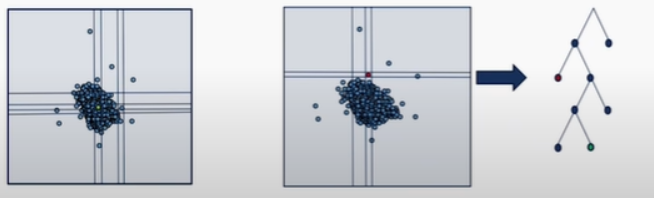









In [25]:
from sklearn. ensemble import IsolationForest

model = IsolationForest(contamination = 0.005 , max_features = 3 , max_samples = 0.8 , n_estimators = 200)

model.fit(data)

IsolationForest(contamination=0.005, max_features=3, max_samples=0.8,
                n_estimators=200)

In [27]:

# Anomalous data points 

df_final['outliers'] = pd.Series(model.predict(data)).apply(lambda x :  'yes' if (x == -1) else 'no')


df_final.query('outliers == "yes" ')


,timestamp,value,hour,weekday,value_avg,day,outliers
1488,2014-09-01 00:00:00,13763.0,0,Monday,8020.283333,0,yes
1631,2014-09-06 23:00:00,29418.5,23,Saturday,25192.516129,5,yes
2640,2014-10-19 00:00:00,27146.5,0,Sunday,23898.733333,6,yes
2977,2014-11-02 01:00:00,37204.5,1,Sunday,21593.533333,6,yes
4271,2014-12-25 23:00:00,7977.5,23,Thursday,20732.241935,3,yes
4416,2015-01-01 00:00:00,25850.0,0,Thursday,12698.500000,3,yes
4417,2015-01-01 01:00:00,29292.0,1,Thursday,8132.564516,3,yes
4418,2015-01-01 02:00:00,25753.5,2,Thursday,5350.209677,3,yes
4419,2015-01-01 03:00:00,22067.0,3,Thursday,3683.177419,3,yes
4511,2015-01-04 23:00:00,8402.0,23,Sunday,11686.450000,6,yes


In [28]:
fig = px.scatter(df_final , x = "timestamp" , y = "value" , color = "outliers" , hover_data = ["weekday" , "hour" , "value_avg"] , title = "NYC Taxi Demand")

fig.update_xaxes(rangeslider_visible = True)
fig.show()

- AS we can see , the isolation forest did a pretty goof job in identifying anomalies , with feature engineering , and if we have multiple time series data , isolation forest can do a pretty  good job .


- we should  too many anomalies , but , in order , to get a more general aspect of these anomalies , we will set a threshold ,in order to get the most influential ones , because the more we are specific the more we include more data points etc and small differences , will be considered as anomalies , we don't want that .

- so we'll set a score to get the top 5 or top 10 anomalies


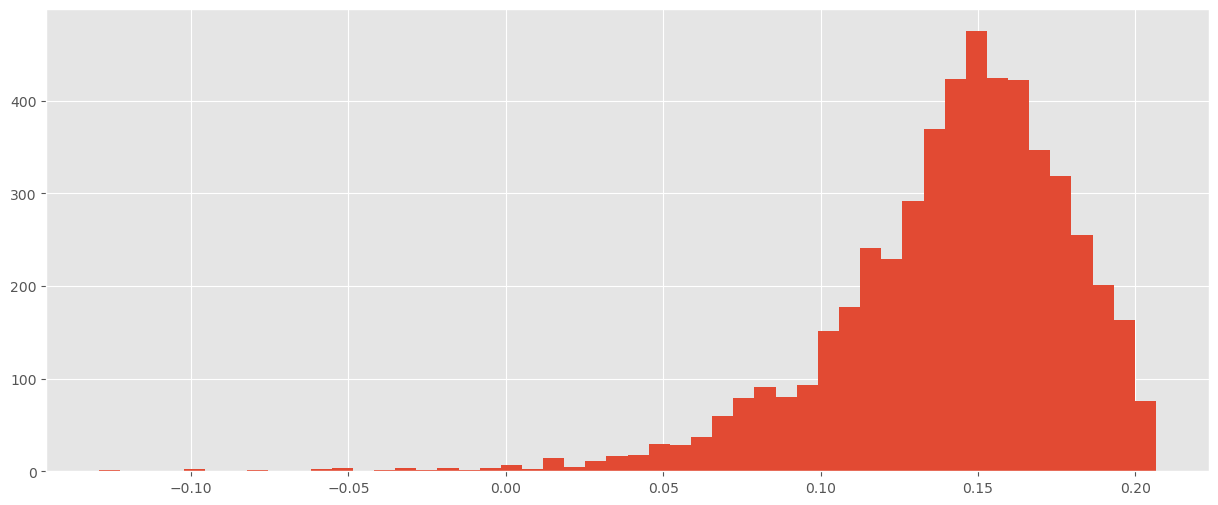

In [30]:
# Histogram of scores
score = model.decision_function(data)

plt.hist(score,bins=50);

In [34]:
# we can do a cutoff in -0.05 , these are some anomalous points

df_final["scores"] = score

df_final.query("scores<-0.04")

,timestamp,value,hour,weekday,value_avg,day,outliers,scores
1631,2014-09-06 23:00:00,29418.5,23,Saturday,25192.516129,5,yes,-0.041541
2977,2014-11-02 01:00:00,37204.5,1,Sunday,21593.533333,6,yes,-0.129166
4416,2015-01-01 00:00:00,25850.0,0,Thursday,12698.500000,3,yes,-0.049932
4417,2015-01-01 01:00:00,29292.0,1,Thursday,8132.564516,3,yes,-0.097741
4418,2015-01-01 02:00:00,25753.5,2,Thursday,5350.209677,3,yes,-0.050062
5036,2015-01-26 20:00:00,3630.5,20,Monday,19880.766667,0,yes,-0.050339
5037,2015-01-26 21:00:00,2907.0,21,Monday,19197.350000,0,yes,-0.056867
5038,2015-01-26 22:00:00,1324.5,22,Monday,17191.700000,0,yes,-0.079172
5039,2015-01-26 23:00:00,243.0,23,Monday,12863.000000,0,yes,-0.100483
5040,2015-01-27 00:00:00,94.5,0,Tuesday,8483.709677,1,yes,-0.059634


- This confirms so well that the events we provided create anomalous data points in our time series 

- Our next goal is to inform the prophet model about these special events ,  in order to improve our forecast .

- Prophet offers robust capabilities to incorporate holiday effects into your forecasts. Moreover, the methodologies employed in Prophet to incorporate holiday effects can also be extended to include any holiday-like event.

- You can also control the strength of these special days by doing regularization .

- Prophet utilizes the Python holidays package to automatically generate a predefined set of holidays based on the chosen country, and optionally, state or province. This enables the selection of a specific region to compile a list of holidays

### Adding holiday effects 

- Each state in the U.S. has its own set of recognized state holidays or observances. These can include statehood day, state holidays commemorating historical events or figures specific to that state, or even days of recognition for particular industries or causes. Examples include "Pioneer Day" in Utah, "Emancipation Day" in some states, and various state holidays honoring local historical figures.

- in our case we'll add custom holidays in our data 



## Load data

In [132]:

df = pd .read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv" , parse_dates = True)

df["timestamp"] = pd.to_datetime(df["timestamp"])

df = df.set_index("timestamp").resample("H").mean().reset_index()


In [166]:


df.columns  = ["ds","y"]



In [193]:

from sklearn.metrics import mean_squared_error, mean_absolute_error


Snow_Blizzard = pd.DataFrame({'holiday': 'Snow_Blizzard',
                              'ds': pd.to_datetime(
                                  ['2015-01-26']),'lower_window': 0,'upper_window': 1,'prior_scale': 4.861680615112172})

Snow_Blizzard = Snow_Blizzard[["ds","holiday","lower_window","upper_window"]]




Thanksgiving = pd.DataFrame({'holiday': 'Thanksgiving',
                                  'ds': pd.to_datetime(
                                      ['2014-11-27']),'prior_scale':2.0820778020028414})




new_year = pd.DataFrame({'holiday': 'new_year',
                                  'ds': pd.to_datetime(
                                      ['2015-01-01']),'prior_scale':3.0272349876751266})





Christmas = pd.DataFrame({'holiday': 'Christmas',
                                  'ds': pd.to_datetime(
                                      ['2014-12-25']),'prior_scale':0.9932792600906482})

Christmas = Christmas[["ds","holiday"]]



holidays = pd.concat([Snow_Blizzard,
                          Thanksgiving,new_year,Christmas]).sort_values('ds')\
                         .reset_index(drop=True)


model = Prophet(seasonality_mode='additive',holidays=holidays)



model.fit(df)




future = model.make_future_dataframe(periods=0,freq='H')

# Add country holidays 




forecast = model.predict(future)


len_df = df.shape[0]

predictions = forecast.yhat




predictions = forecast.yhat



rmse_train = np.sqrt(mean_squared_error(df.y,predictions))

mae_train = mean_absolute_error(df.y,predictions)


print(f"RMSE_train:{rmse_train} ; MAE_train:{mae_train} ")





13:51:17 - cmdstanpy - INFO - Chain [1] start processing
13:51:18 - cmdstanpy - INFO - Chain [1] done processing


RMSE_train:3637.549505628967 ; MAE_train:2775.584447203602 


In [112]:
from sklearn.metrics import mean_squared_error , mean_absolute_error
import optuna

def objective(trial):

    
  #  prior_scale1 = trial.suggest_float("prior_scale1",0.01,10,log=True)
    
   # prior_scale2 = trial.suggest_float("prior_scale2",0.01,10,log=True)
   # prior_scale3 = trial.suggest_float("prior_scale3",2.9,3.5,log=True)
    
    #prior_scale4 = trial.suggest_float("prior_scale4",0.8,1.5,log=True)
    
    prior_scale5 = trial.suggest_float("prior_scale5",0.01,10,log=True)




    Snow_Blizzard = pd.DataFrame({'holiday': 'Snow_Blizzard',
                                  'ds': pd.to_datetime(
                                      ['2015-01-26']),'lower_window': 0,'upper_window': 1,'prior_scale': 4.861680615112172})

    Snow_Blizzard = Snow_Blizzard[["ds","holiday","lower_window","upper_window"]]




    Thanksgiving = pd.DataFrame({'holiday': 'Thanksgiving',
                                      'ds': pd.to_datetime(
                                          ['2014-11-27']),'prior_scale':2.0820778020028414})




    new_year = pd.DataFrame({'holiday': 'new_year',
                                      'ds': pd.to_datetime(
                                          ['2015-01-01']),'prior_scale':3.0272349876751266})





    Christmas = pd.DataFrame({'holiday': 'Christmas',
                                      'ds': pd.to_datetime(
                                          ['2014-12-25']),'prior_scale':0.9932792600906482})

    Christmas = Christmas[["ds","holiday"]]

  

    nyc_marathon = pd.DataFrame({'holiday': 'nyc_marathon',
                                  'ds': pd.to_datetime(
                                      ['2014-11-02']),'prior_scale':prior_scale5})

    
    nyc_marathon = nyc_marathon[["ds","holiday"]]
    
    holidays = pd.concat([Snow_Blizzard,
                          Thanksgiving,new_year,Christmas,nyc_marathon]).sort_values('ds')\
                         .reset_index(drop=True)



    
    
    
    
    
    
    
    

    holidays = holidays
    model2 = Prophet(seasonality_mode='additive',holidays=holidays)

    model2.fit(train)

    future = model2.make_future_dataframe(periods=test.shape[0],freq='H')

    forecast = model2.predict(future)

    len_df = df.shape[0]


    predictions = forecast.yhat

    actuals_train = train.y

    actuals_test = test.y

    rmse_test = np.sqrt(mean_squared_error(actuals_test,predictions[-test.shape[0]:]))

    mae_test = mean_absolute_error(actuals_test,predictions[-test.shape[0]:])


    rmse_train = np.sqrt(mean_squared_error(actuals_train,predictions[:train.shape[0]]))

    mae_train = mean_absolute_error(actuals_train,predictions[:train.shape[0]])




    return mae_test

In [113]:

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))


print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-10-04 12:38:24,466] A new study created in memory with name: no-name-bca556ec-5b06-4c6f-9854-089e4b69a4a8
12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-04 12:38:27,837] Trial 0 finished with value: 3136.01681184686 and parameters: {'prior_scale5': 0.09914852226643471}. Best is trial 0 with value: 3136.01681184686.
12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-04 12:38:31,185] Trial 1 finished with value: 3136.01681184686 and parameters: {'prior_scale5': 0.1923722105377588}. Best is trial 0 with value: 3136.01681184686.
12:38:31 - cmdstanpy - INFO - Chain [1] start processing
12:38:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-04 12:38:34,689] Trial 2 finished with value: 3136.01681184686 and parameters: {'prior_scale5': 5.8989588425281045}. Best is trial 0 with value: 3136.01681184686.
12:38:35 - cmdstanpy - I

KeyboardInterrupt: 

 trial 1
 
    prior_scale1: 4.861680615112172
   
    prior_scale2: 2.0820778020028414
    
    prior_scale3: 3.2033670254864375
    
    prior_scale4: 0.04786458560266206
    
    
    3972.668740757962
    
trial2 
    
      Value: 3972.2026394634504
 
    prior_scale3: 3.0272349876751266
    prior_scale4: 0.9932792600906482